In [1]:
from src.utils import get_parser, Explorer



if you are in local jupyter notebook, open this notebook and change codes to change the option(you can't see codes through voila).

- Avaliable `data_type`: `"mnist"`, `"cifar10"`
- Avaliable `option`:
    * Mnist Data: `"roar"`, `"kar"`
    * Cifar10 Data: `"roar"`, `"kar-rcd"`, `"roar-rcd"`, `"roar-rcd-fgm"`

```
args = get_parser(data_type="cifar10", option="roar-rcd")
explorer = Explorer(args)
explorer.show()
```

i'll show "roar" for mnist datas, "roar-rcd" for cifar10 datas as default

# [XAI Tutorial 02] Attention Methods (domain: vision)

## TOC

1. [Attention Modules](#Attention-Modules)
    * [CBAM](#CBAM)
    * [ANR](#ANR)
2. [Evaluation](#Evaluation)
    * ROAR & KAR

---

# Attention Modules

This article only describes the approach methods, for more detail information please visit the referenced paper.

## CBAM
* Figures are from the paper: [CBAM: Convolutional Block Attention Module](https://arxiv.org/abs/1807.06521)

<figure class="image">
    <img src="https://drive.google.com/uc?id=1cMiIUUEgwAGxpCjawxfPnH2aQqXZxJfm" alt="cbam" width="640px" height="320px">
    <figcaption></figcaption>
</figure>

Convolutional Block Attention Module contains 2 blocks: **channel attention map** $M_c=(C, 1, 1)$ and **spatial attention map** $M_s=(1, H, W)$

$\begin{aligned} F &\in \Bbb{R}^{C \times H \times W} \\ M_c &\in \Bbb{R}^{C \times 1 \times 1} \\ M_s &\in \Bbb{R}^{1 \times H \times W} \end{aligned}$

The whole process will be like 

$\begin{aligned} F_1 &= M_c(F) \otimes F \\ F_2 &= M_s(F_1) \otimes F_1 \end{aligned}$

<figure class="image">
    <img src="https://drive.google.com/uc?id=1_9tqmaESkaPMNkA9fDfGbMDfTPmcY9ZA" alt="cbam" width="640px" height="320px">
    <figcaption></figcaption>
</figure>

### Channel Attention Module

In Channel Attention Module, input tensor $F=(B, C, H, W)$ will go thorugh max pooling layer and average pooling layer to aggregate feature information by getting two pooled features which has size of $(B, C, 1, 1)$  Then concatenate two features in to one feature($(B, 2C)$) as the input of point-wise feed forward network. After this,  chunk the output into two tensor. One represent linear combinated max pooled vector, the other represent linear combinated averate pooled vector. Add them together and go through sigmoid function to get channel attention vector $M_c$. The Output will be element-wise multiplication of channel attention vector and input tensor($F_1 = M_c * F$).

This module focues on "what" is meaningful given an input image. The author didn't use `softmax` function to get the probability of this vector. In my personal opinion, going through the `sigmoid` making this module works like a gate function(which means features in each channels are independent), so that the model can decide which channel is important from the aggregated information value in each channel.

### Spatial Attention Module

In Spatial Attention Module, input tensor will be channel-attentioned(refined) tensors($F_1$). This time apply max pooling and average pooling along the channel axis to get 1 dimension channel feature map. Then concatenate two maps and get a new feature map called "spatial attention map"($F_2=(B, 1, H, W)$) by a convolution operation with same padding and kernel size is 7, and sigmoid function for activation.

This module focuses on "where" is an informative part of channel attentioned map.


> Can see the implemented code at [`torchxai.module.cbam`]()

---

## ANR

* Figures are from the paper: [Attend and Rectify: a Gated Attention Mechanism for Fine-Grained Recovery](https://arxiv.org/abs/1807.07320)

<figure class="image">
    <img src="https://drive.google.com/uc?id=1fhgMGkgqVZFRBFsSo6N6la_WuYzkYRwZ" alt="anr1" width="640px" height="320px">
    <figcaption></figcaption>
</figure>

This attention modules have the same idea in "Transformer" attention module which has "$K$" attention heads after each convolution blocks. After each convolution block outputs will create attended output vectors which have size of $(B, L)$, $B$ is mini-batch size, $L$ is number of classes. This means that after each convolution block let the model derive a hypothesis to guess the target. All hypotheses will be used at "Global Attention Gates" to predict final output.

### Attention Modules

<figure class="image">
    <img src="https://drive.google.com/uc?id=1pxhoS2ajGv3yMeECwoNIjmruLJarWyMR" alt="anr2" width="640px" height="320px">
    <figcaption></figcaption>
</figure>

### Attention Head

$\mathbf{H}^l = \text{spatial_softmax}(\mathbf{W}_H^l * \mathbf{Z}^l)$

In Attention Head Module, input tensor will be output of covolution block(something like `Conv2d-ReLU-MaxPool2d` or Residual Block, which has output size of $(B, C, H, W)$). First, linear combinate the input tensor using a 3x3 convolution operation with same padding and $K$ output channel which means number of attention heads. The output of convolution will be $(B, K, H, W)$ and use `softmax` function along the channel dimension to get importance of spatial information for each head called "Attention Masks"($H^l=(B, K, H, W)$, $l$ means the index of convolution block in the model).

The spatial softmax will enforce the model to learn the mose relevant region of the image.

### Output Head and Layered Attention Gates

The process is similar to Attention Head Module part which use the input tensor and 3x3 convoltuion, bud with different output channels. Layered Attention Gates have same size of output channels($K$), while Output Heads have $K\times L$ output channels. Then two module combine "Attention Masks" to get different outputs.

The output of convolution operation in Output Head Module at $k^{th}$ head after $l^{th}$ convolution block writes as $\mathbf{O}_k^l = (B, K\times L, H, W)$ and the output of convolution operation Layered Attention Gates after $l^{th}$ convolution block is $\mathbf{G}_{H}^l=(B, K, H, W)$.

The Output Head Module($\mathbf{o}^l$) calculate weighted averaged tensors$(B, K, L)$ which combines the spatial information from "Attention Masks" and the output of convoluted features in the Output Head Module. The forumla will be like below.

$\begin{aligned}\mathbf{O}_k^l &= \mathbf{W}_{O^k}^l * \mathbf{Z}^l \\ \mathbf{o}_k^l &= \sum_{x, y} \mathbf{H}_k^l \odot \mathbf{O}_k^l \end{aligned}$

where $x, y$ are pixeles in each axis(means calculate summation of all spatial dimensions). Each $\mathbf{o}_k^l$ can be seen as a hypothesis to guess targets.

The Layered Attention Gates Module calculate $K$ heads weights$(B, K, 1)$ for each Output Head Module($\mathbf{o}_k^l$). The formula will be like below.

$\begin{aligned}\mathbf{G}^l &= \mathbf{W}_{G}^l * \mathbf{Z}^l \\ \mathbf{g}^l &= \text{softmax}\Big( \tanh\big(\sum_{x, y} \mathbf{H}^l \odot \mathbf{G}^l \big) \Big) \end{aligned}$

where $x, y$ are pixeles in each axis(means calculate summation of all spatial dimensions). Each $\mathbf{g}_k^l$ can be seen as a weight for each hypothesis $\mathbf{o}_k^l$. 

At last combine the $\mathbf{g}_k^l$ and $\mathbf{o}_k^l$ by weighted sum along $K$ dimension to get final hypothesis after $l^{th}$ convolution block.

$\mathbf{o}^l = \sum_k \mathbf{g}_k^l \mathbf{o}_k^l$

### Global Attention Gates

The Global Attention Gates combines all hypotheses from the outputs of the Attention Blocks($\mathbf{o} = (B, N, L)$) and the global gate $\mathbf{g}_O$. The global gate can be calculated from the average-pooled last convolution block output$\text{avgpool}(\mathbf{Z}^L)$.

$\begin{aligned} \mathbf{c} &= \mathbf{W}_c \text{avgpool}(\mathbf{Z}^L) \\ \mathbf{g}_O &= \text{softmax}(\mathbf{c})\end{aligned}$

At last, apply following function to get the final outputs of modle.

$\text{outputs} = \sum_{i=1}^N \mathbf{g}_O^{(i)} \times \mathbf{o}^{(i)}$

> Can see the implemented code at [`torchxai.module.anr`]()

---

# Evaluation

1. Qualitative: See Attribution Maps with Mnist / Cifar10 Datas
2. Quantitative: watch test accuracy in ROAR/KAR is decreasing.

Build a Baseline model which create a attribution map by random values from [0, 1).

### ROAR-MNIST

In [2]:
mnist_roar_args = get_parser(data_type="mnist", option="roar")
mnist_roar_explorer = Explorer(mnist_roar_args)
mnist_roar_explorer.show()

Output()

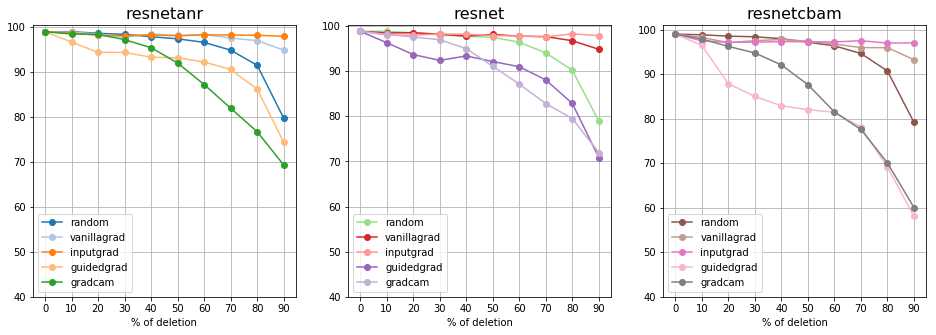

In [3]:
mnist_roar_explorer.show_eval()

### KAR-MNIST

In [4]:
mnist_kar_args = get_parser(data_type="mnist", option="kar")
mnist_kar_explorer = Explorer(mnist_kar_args)
mnist_kar_explorer.show()

Output()

* percent of recover at 0 means the test accuracy for model's first trained result.

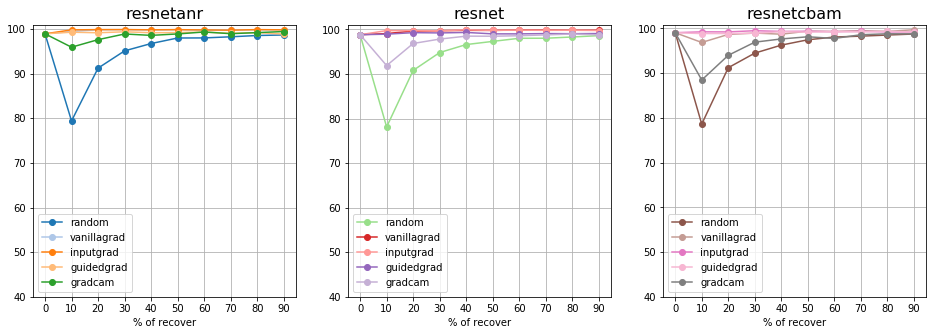

In [5]:
mnist_kar_explorer.show_eval()

### ROAR-CIFAR10

In [6]:
cifar10_args = get_parser(data_type="cifar10", option="roar-rcd")
cifar10_explorer = Explorer(cifar10_args)
cifar10_explorer.show()

Files already downloaded and verified
Files already downloaded and verified


Output()

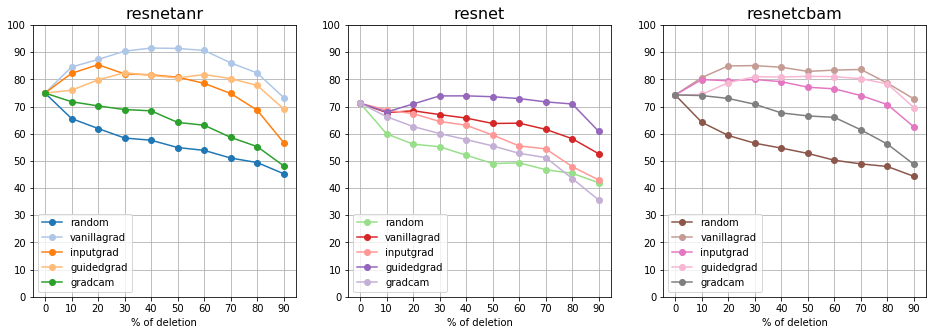

In [7]:
cifar10_explorer.show_eval()